# Database creation
This file is used to play with the data and once the objective is reached, functions will be written in .py files in order to be used by the model part of the project.

In [1]:
from astropy.io import fits
from tabulate import tabulate
from astropy.time import Time, TimeDelta
from dataset_creation_utils import HiddenPrints, find_lower_upper_bound, get_folder_names
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from dataset_creation_utils import *
from dataset import Dataset
# Retrieve the contrast curves from the database

path_db = '/Users/ludo/Documents/TFE/Master-Thesis/Dataset_creation/SPHERE_DC_DATA'

# Contrast curve
path_db_contrast = '/Users/ludo/Documents/TFE/Master-Thesis/Dataset_creation/SPHERE_DC_DATA/contrast_curves/'
foldername = '2MASS-J02423301-5739367_DB_H23_2015-11-29_ird_specal_dc_cADI_softsorting_161077/'
filename = 'ird_specal_dc-IRD_SPECAL_CONTRAST_CURVE_TABLE-contrast_curve_tab.fits'

if not os.path.exists(path_db_contrast):
    print('ERROR! Folder {} does not exist.'.format(path_db_contrast)) # exit doesn't print anything in jupyter notebook

if not os.path.exists(os.path.join(path_db_contrast, foldername)):
    print('ERROR! Folder {} does not exist.'.format(foldername))

if not os.path.exists(os.path.join(path_db_contrast, foldername, filename)):
    print('ERROR! File {} does not exist.'.format(filename))

# Example of how to read a fits file
with fits.open(os.path.join(path_db_contrast, foldername, filename)) as hdul:
    hdul.info()
    data = hdul[1].data #numpy record
    headers = hdul[1].header #dictionary
    print(data.dtype)
    # print(hdul[1].header['DATE-OBS'])
    # print(hdul[1].data['TARGET_NAME'])

Filename: /Users/ludo/Documents/TFE/Master-Thesis/Dataset_creation/SPHERE_DC_DATA/contrast_curves/2MASS-J02423301-5739367_DB_H23_2015-11-29_ird_specal_dc_cADI_softsorting_161077/ird_specal_dc-IRD_SPECAL_CONTRAST_CURVE_TABLE-contrast_curve_tab.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1                1 BinTableHDU   1008   3R x 7C   [15A, 10A, 10A, 3A, 55A, 958E, 958E]   
(numpy.record, [('TARGET_NAME', 'S15'), ('LAM', 'S10'), ('PIXSCALE', 'S10'), ('NSIGMA', 'S3'), ('REPERTORY', 'S55'), ('SEPARATION', '>f4', (958,)), ('NSIGMA_CONTRAST', '>f4', (958,))])


Now we need to investiguate the sampledata and timestamps files.
1. Sparta_sampledata where the info is not available

In [2]:
# Sparta data
path_db_sparta = '/Users/ludo/Documents/TFE/Master-Thesis/Dataset_creation/SPHERE_DC_DATA/sparta_sampleddata'
foldername_sparta = '2MASS-J01543773+0043005_2014-10-07_ird_convert_recenter_dc5_PUBLIC_200928/'
filename_sparta = 'ird_convert_recenter_dc5-SPH_SPARTA_SAMPLEDDATA-sampled_sparta_data.fits'

if not os.path.exists(path_db_sparta):
    print('ERROR! Folder {} does not exist.'.format(path_db_sparta)) # exit doesn't print anything in jupyter notebook

if not os.path.exists(os.path.join(path_db_sparta, foldername_sparta)):
    print('ERROR! Folder {} does not exist.'.format(foldername_sparta))

if not os.path.exists(os.path.join(path_db_sparta, foldername_sparta, filename_sparta)):
    print('ERROR! File {} does not exist.'.format(filename_sparta))

with fits.open(os.path.join(path_db_sparta, foldername_sparta, filename_sparta)) as hdul:
    data = hdul[0].data #numpy record
    headers = hdul[0].header #dictionary
    print(hdul.info())
    # data dimensions
    print(data.shape)
    # print(data[0])
    
# hdul = fits.open(os.path.join(path_db_sparta, foldername_sparta, filename_sparta))
# hdul[0].header

Filename: /Users/ludo/Documents/TFE/Master-Thesis/Dataset_creation/SPHERE_DC_DATA/sparta_sampleddata/2MASS-J01543773+0043005_2014-10-07_ird_convert_recenter_dc5_PUBLIC_200928/ird_convert_recenter_dc5-SPH_SPARTA_SAMPLEDDATA-sampled_sparta_data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1014   (90, 7)   float64   
None
(7, 90)


2. Sparta_sample data where the info is available 

In [3]:
# Sparta data
path_db_sparta = '/Users/ludo/Documents/TFE/Master-Thesis/Dataset_creation/SPHERE_DC_DATA/sparta_sampleddata'
foldername_sparta = '2MASS-J04522441-1649219_2016-01-17_ird_convert_recenter_dc5_84472/'
filename_sparta = 'ird_convert_recenter_dc5-SPH_SPARTA_SAMPLEDDATA-sampled_sparta_data.fits'

if not os.path.exists(path_db_sparta):
    print('ERROR! Folder {} does not exist.'.format(path_db_sparta)) # exit doesn't print anything in jupyter notebook

if not os.path.exists(os.path.join(path_db_sparta, foldername_sparta)):
    print('ERROR! Folder {} does not exist.'.format(foldername_sparta))

if not os.path.exists(os.path.join(path_db_sparta, foldername_sparta, filename_sparta)):
    print('ERROR! File {} does not exist.'.format(filename_sparta))

with fits.open(os.path.join(path_db_sparta, foldername_sparta, filename_sparta)) as hdul:
    data = hdul[0].data #numpy record
    headers = hdul[0].header #dictionary
    print(hdul.info())
    # data dimensions
    print(data.shape)
    # print(data)
    
# hdul = fits.open(os.path.join(path_db_sparta, foldername_sparta, filename_sparta))
# hdul[0].header

Filename: /Users/ludo/Documents/TFE/Master-Thesis/Dataset_creation/SPHERE_DC_DATA/sparta_sampleddata/2MASS-J04522441-1649219_2016-01-17_ird_convert_recenter_dc5_84472/ird_convert_recenter_dc5-SPH_SPARTA_SAMPLEDDATA-sampled_sparta_data.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU     980   (72, 7)   float64   
None
(7, 72)


3. Timestamps

In [4]:
# Timestamps
path_db_timestamps = '/Users/ludo/Documents/TFE/Master-Thesis/Dataset_creation/SPHERE_DC_DATA/timestamps'
foldername_timestamps = '2MASS-J01543773+0043005_DB_H23_2014-10-07_ird_convert_recenter_dc5_PUBLIC_200928/'
filename_timestamps = 'ird_convert_recenter_dc5-IRD_TIMESTAMP-timestamp.fits'

if not os.path.exists(path_db_timestamps):
    print('ERROR! Folder {} does not exist.'.format(path_db_sparta)) # exit doesn't print anything in jupyter notebook

if not os.path.exists(os.path.join(path_db_timestamps, foldername_timestamps)):
    print('ERROR! Folder {} does not exist.'.format(foldername_timestamps))

if not os.path.exists(os.path.join(path_db_timestamps, foldername_timestamps, filename_timestamps)):
    print('ERROR! File {} does not exist.'.format(filename_timestamps))

with fits.open(os.path.join(path_db_timestamps, foldername_timestamps, filename_timestamps)) as hdul:
    data = hdul[0].data #numpy record
    headers = hdul[0].header #dictionary
    print(hdul.info())
    # data dimensions
    print(data.shape)
    # print(data)
    
# hdul = fits.open(os.path.join(path_db_timestamps, foldername_timestamps, filename_timestamps))
# hdul[0].header['SUBTRACT']

Filename: /Users/ludo/Documents/TFE/Master-Thesis/Dataset_creation/SPHERE_DC_DATA/timestamps/2MASS-J01543773+0043005_DB_H23_2014-10-07_ird_convert_recenter_dc5_PUBLIC_200928/ird_convert_recenter_dc5-IRD_TIMESTAMP-timestamp.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU    1014   (90,)   float64   
None
(90,)


In [5]:
contrast_folder_names = get_folder_names(path_db_contrast)
sparta_folder_names = get_folder_names(path_db_sparta)
timestamps_folder_names = get_folder_names(path_db_timestamps)

print('Number of contrast folders: {}'.format(len(contrast_folder_names)))
print('Number of sparta folders: {}'.format(len(sparta_folder_names)))
print('Number of timestamps folders: {}'.format(len(timestamps_folder_names)))

contrast_folder_names_split = [folder.split('_') for folder in contrast_folder_names]
sparta_folder_names_split = [folder.split('_') for folder in sparta_folder_names]
timestamps_folder_names_split = [folder.split('_') for folder in timestamps_folder_names]

# For each element of the first column, we want to replace '-' by ' '
for i, folder in enumerate(contrast_folder_names_split):
    contrast_folder_names_split[i][0] = contrast_folder_names_split[i][0].replace('-', ' ')

for i, folder in enumerate(sparta_folder_names_split):
    sparta_folder_names_split[i][0] = sparta_folder_names_split[i][0].replace('-', ' ')

for i, folder in enumerate(timestamps_folder_names_split):
    timestamps_folder_names_split[i][0] = timestamps_folder_names_split[i][0].replace('-', ' ')

# print("contrast : {}".format(contrast_folder_names_split[0]))
# print("sparta : {}".format(sparta_folder_names_split[0]))
# print("timestamps : {}".format(timestamps_folder_names_split[0]))

sparta_dic = {}
timestamps_dic = {}

sparta_missings = []
timestamps_missings = []

for i, folder in enumerate(contrast_folder_names):

    sparta_miss = True
    timestamps_miss = True

    for j, sparta_folder in enumerate(sparta_folder_names):
        if contrast_folder_names_split[i][0] == sparta_folder_names_split[j][0] \
            and contrast_folder_names_split[i][3] == sparta_folder_names_split[j][1]:
            sparta_dic[folder] = sparta_folder
            sparta_miss = False
            break

    for j, timestamps_folder in enumerate(timestamps_folder_names):
        if contrast_folder_names_split[i][0] == timestamps_folder_names_split[j][0] \
            and contrast_folder_names_split[i][3] == timestamps_folder_names_split[j][3]:
            timestamps_dic[folder] = timestamps_folder
            timestamps_miss = False
            break

    if sparta_miss:
        sparta_missings.append(folder)
    
    if timestamps_miss:
        timestamps_missings.append(folder)
            
print("Length of the mapping using sparta {}".format(len(sparta_dic)))
print("Length of the mapping using timestamps {}".format(len(timestamps_dic)))

# Transform the dictionary into a dataframe and then into a csv file
df_sparta = pd.DataFrame.from_dict(sparta_dic, orient='index', columns=['sparta_folder'])
df_sparta.to_csv('sparta_mapping.csv')

df_timestamps = pd.DataFrame.from_dict(timestamps_dic, orient='index', columns=['timestamps_folder'])
df_timestamps.to_csv('timestamps_mapping.csv')

# Put in a text file the missing folders
with open('sparta_missings.txt', 'w') as f:
    for item in sparta_missings:
        f.write(item + "\n")

with open('timestamps_missings.txt', 'w') as f:
    for item in timestamps_missings:
        f.write(item + "\n")

Number of contrast folders: 847
Number of sparta folders: 736
Number of timestamps folders: 826
Length of the mapping using sparta 817
Length of the mapping using timestamps 819


Get a dataframe with the specified headers. Plots, summary statistics, ... can be computed if desired (not to be re-done each time).

In [6]:
dataset = Dataset(path_db, max_sep=3, write=False, plot=False)

Creating the dataset...


100%|██████████| 847/847 [05:09<00:00,  2.73it/s]


In [7]:
dataset.print_missings_percentages()
dataset.get_missings_csv()

ESO OBS ID: 0.00%
DATE-OBS: 0.00%
OBJECT: 0.00%
ESO TEL AIRM MEAN: 78.04%
EFF_NFRA: 76.74%
EFF_ETIM: 76.74%
SR_AVG: 39.20%
ESO INS4 FILT3 NAME: 0.00%
ESO INS4 OPTI22 NAME: 0.00%
ESO AOS VISWFS MODE: 0.00%
ESO TEL AMBI WINDSP: 0.00%
SCFOVROT: 0.00%
SC MODE: 0.00%
ESO TEL AMBI RHUM: 0.00%
HIERARCH ESO INS4 TEMP422 VAL: 1.53%
HIERARCH ESO TEL TH M1 TEMP: 0.00%
HIERARCH ESO TEL AMBI TEMP: 0.00%
OBS_STA: 78.04%
OBS_END: 78.04%
ESO DET NDIT: 0.00%
ESO DET SEQ1 DIT: 0.00%
SIMBAD_FLUX_G: 1.18%
SIMBAD_FLUX_H: 4.25%
SEEING_MEDIAN: 11.57%
SEEING_STD: 11.57%
COHERENCE_TIME_MEDIAN: 11.57%
COHERENCE_TIME_STD: 11.57%
OBS_STA_TIMESTAMPS: 3.90%
OBS_END_TIMESTAMPS: 3.90%


In [8]:
df = dataset.get_dataframe()
start_recov = df['OBS_STA_TIMESTAMPS']
start_original = df['OBS_STA']
end_recov = df['OBS_END_TIMESTAMPS']
end_original = df['OBS_END']
# for i in range(len(start_recov)):
#     print("Start recovery: {}\n".format(start_recov[i]))
start_recov
    

0      2015-04-30T04:47:07.150
1      2016-12-15T07:26:46.430
2      2017-07-19T23:58:02.510
3      2018-10-19T07:42:28.080
4      2018-03-17T09:01:22.510
                ...           
842    2016-10-28T23:59:19.680
843    2015-04-12T04:23:10.030
844    2015-06-22T06:56:30.750
845    2018-10-09T07:45:29.760
846    2015-10-27T04:20:29.570
Name: OBS_STA_TIMESTAMPS, Length: 847, dtype: object

In [9]:
def sec_diff(recov, original, threshold=500):
    # Check wether the dimensions match
    if recov.shape != original.shape:
        print('ERROR! The dimensions of the two arrays do not match.')
        return

    diff = np.zeros(recov.shape[0])

    outliers = []
    
    for i in range(recov.shape[0]):
        # Check for None values 
        if recov[i] is None or original[i] is None:
            diff[i] = np.nan
        else:
            tmp = Time(recov[i]) - Time(original[i])
            diff[i] = tmp.sec
            if diff[i] > threshold or diff[i] < -threshold:
                outliers.append(i)

    return diff, outliers

In [10]:
def interval_diff(start_recov, end_recov, start_original, end_original, threshold=200):
    # Check wether the dimensions match
    if start_recov.shape != start_original.shape or end_recov.shape != end_original.shape:
        print('ERROR! The dimensions of the two arrays do not match.')
        return

    diff = np.zeros(start_recov.shape[0])

    outliers = []
    
    for i in range(start_recov.shape[0]):
        # Check for None values 
        if start_recov[i] is None or start_original[i] is None or end_recov[i] is None or end_original[i] is None:
            diff[i] = np.nan
        else:
            tmp = Time(end_recov[i]) - Time(start_recov[i]) - (Time(end_original[i]) - Time(start_original[i]))
            diff[i] = tmp.sec
            if diff[i] > threshold or diff[i] < -threshold:
                outliers.append(i)

    return diff, outliers

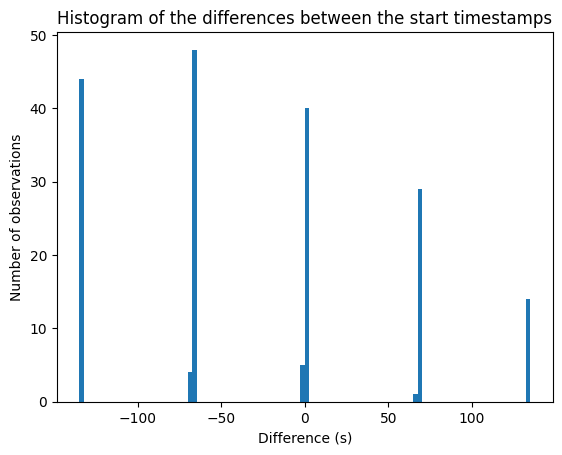

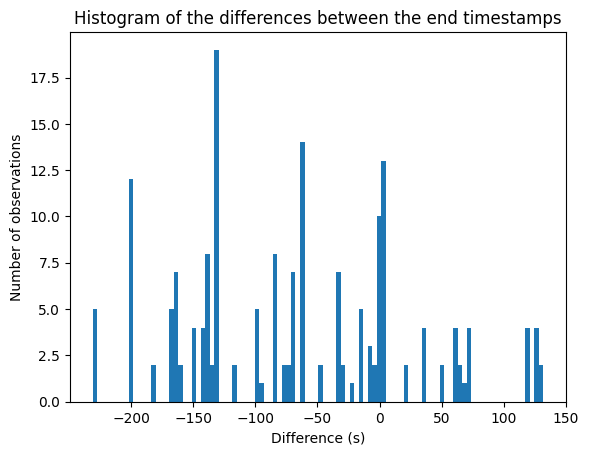

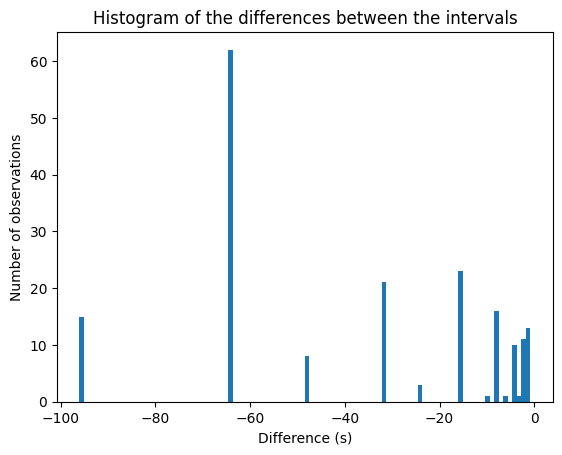

In [11]:
# compute the absolute difference (in seconds) between the recov and original timestamps
# careful, there are missing values
start_diff, outliers_start = sec_diff(start_recov, start_original)
end_diff, outliers_end = sec_diff(end_recov, end_original)
interval_diff, outliers_diff = interval_diff(start_recov, end_recov, start_original, end_original)

# Remove the nan values
start_diff = start_diff[~np.isnan(start_diff)]
end_diff = end_diff[~np.isnan(end_diff)]
interval_diff = interval_diff[~np.isnan(interval_diff)]

# Compute an histogram of the differences
plt.hist(start_diff, bins=100)
plt.title('Histogram of the differences between the start timestamps')	
plt.xlabel('Difference (s)')
plt.ylabel('Number of observations')
plt.show()

plt.hist(end_diff, bins=100)
plt.title('Histogram of the differences between the end timestamps')
plt.xlabel('Difference (s)')
plt.ylabel('Number of observations')
plt.show()

plt.hist(interval_diff, bins=100)
plt.title('Histogram of the differences between the intervals')
plt.xlabel('Difference (s)')
plt.ylabel('Number of observations')
plt.show()

In [12]:
outliers = np.unique(np.concatenate((outliers_start, outliers_end, outliers_diff)))

# Get a new dataframe with the outliers
df_outliers = df.iloc[outliers]
# Write in a file the 'folder' names along with the 'TIMESTAMP_DIR'
df_outliers[['OBS_STA', 'OBS_END', 'OBS_STA_TIMESTAMPS', 'OBS_END_TIMESTAMPS', \
    'folder', 'TIMESTAMPS_DIR']].to_csv('outliers.csv')

In [13]:
# Get the min and max dates 
min_date = df['DATE-OBS'].min()
max_date = df['DATE-OBS'].max()
print('Min date: {}, max date: {}'.format(min_date, max_date))

# Get the number of observations before april 2016
df_before_april = df[df['DATE-OBS'] < '2016-01-01']
print('Number of observations before april 2016: {}'.format(len(df_before_april)))

# Get the number of observations after april 2016
df_after_april = df[df['DATE-OBS'] >= '2016-04-01']
print('Number of observations after april 2016: {}'.format(len(df_after_april)))

Min date: 2014-07-13T09:43:44.923, max date: 2019-03-25T02:18:36.930
Number of observations before april 2016: 392
Number of observations after april 2016: 388


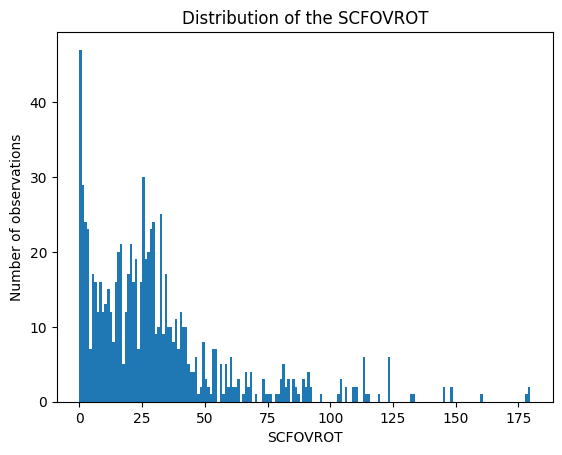

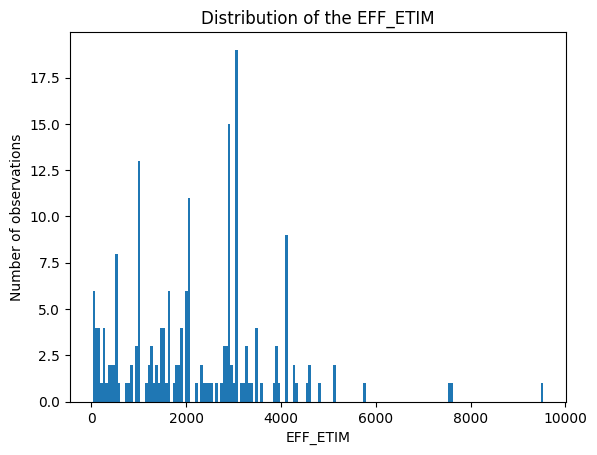

In [14]:
# Plot histogram of the wanted headers
hist_list = ['SCFOVROT', 'EFF_ETIM']

for hist in hist_list:
    try:
        plt.hist(df[hist], bins=180)
        plt.title("Distribution of the {}".format(hist))
        # plt.xlim(0, 360)
        plt.xlabel(hist)
        plt.ylabel("Number of observations")
        plt.show()
    except KeyError:
        print("ERROR! Header {} does not exist.".format(hist))

Number of observations with EFF_ETIM between 0 and 300 seconds : 19 


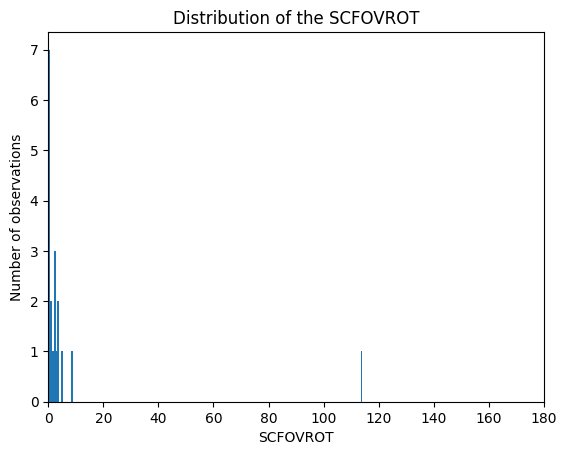

In [15]:
# Keep only the rows where EFF_ETIM is between 0 and 300
new_df = df[(df['EFF_ETIM'] > 0) & (df['EFF_ETIM'] < 300)]
print('Number of observations with EFF_ETIM between 0 and 300 seconds : {} '.format(len(new_df)))

# Plot the histogram of the SCFOVROT
plt.hist(new_df['SCFOVROT'], bins=180)
plt.title("Distribution of the SCFOVROT")
plt.xlim(0, 180)
plt.xlabel('SCFOVROT')
plt.ylabel("Number of observations")
plt.show()
# Careful, EFF_ETIM is missing for a lot of observartions !! 
# I did this part when trying to recover it frome headers with NDIT * DIT
# but Julien told me that EFF_ETIM is not the same as NDIT * DIT

This plot is a summary plot of all the contrast curves, no anomaly detection has been performed.

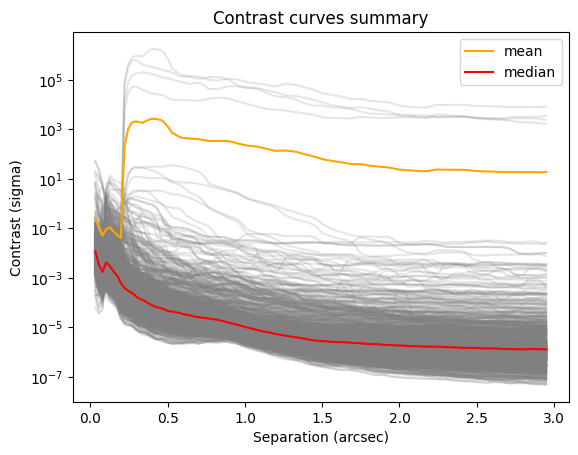

In [16]:
dataset.plot_contrast_curves_summary(filename='contrast_curves_summary_raw.png')

Now the sum of the absolute differences between the contrast curves and the median contrast curve (using log values) is used as deviation measure. The distribution of these deviations is showed and some outliers can be observed.

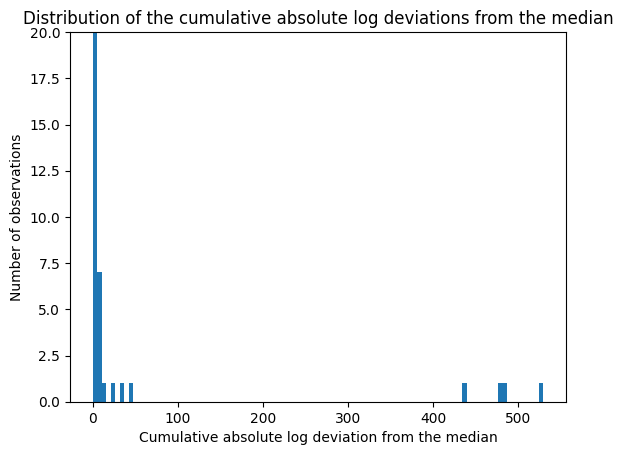

In [17]:
# Plot the distribution of the absolute deviations from the median
plt.hist(dataset.get_contrast_abs_deviations_from_median(), bins=100)	
# plt.xlim(0, 100)
plt.ylim(0, 20)
plt.title("Distribution of the cumulative absolute log deviations from the median")
plt.xlabel("Cumulative absolute log deviation from the median")
plt.ylabel("Number of observations")
plt.show()

The cut-off criterion has been chosen (arbitrarly) and a new summary plot has been computed in order to be compared to the previous one.

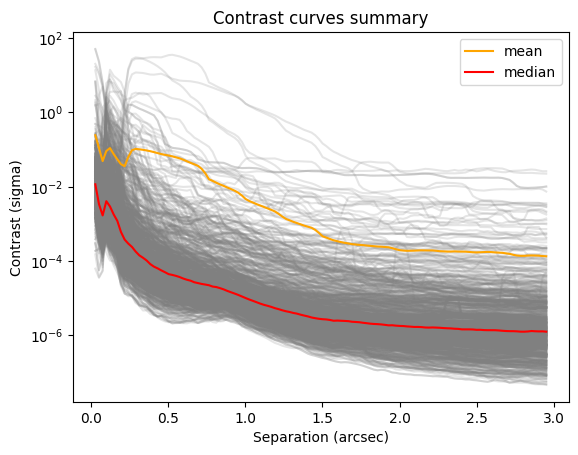

In [18]:
dataset.remove_contrast_anomalies(threshold=100)
dataset.plot_contrast_curves_summary(filename='contrast_curves_summary_anomaly_detection.png')
df_AD = dataset.get_dataframe()

In [19]:
# Save df_AD in a pickle file
df_AD.to_pickle('df_AD_timestamps.pkl')

In [20]:
test = {}
test['a'] = 1
test['b'] = 2
test['c'] = 3

print([''] + list(test.keys()))

['', 'a', 'b', 'c']


In [21]:
from sparta.query_eso_archive import query_ecmwf_jetstream

path = 'C:/Users/ludin/Documents/Master Thesis/Dataset_creation/'

test_df = query_ecmwf_jetstream(path, start_date='2015-09-20T00:00:00.00', end_date='2015-09-21T12:00:00.00')

test_df

wget -O C:/Users/ludin/Documents/Master Thesis/Dataset_creation/ecmwf_jetstream_query_2015-09-20T00:00:00.00_2015-09-21T12:00:00.00.txt http://www.eso.org/asm/api/?from=2015-09-20T00:00:00.00&to=2015-09-21T12:00:00.00Z&fields=asmmetnow-jsspeed
C:/Users/ludin/Documents/Master Thesis/Dataset_creation/ecmwf_jetstream_query_2015-09-20T00:00:00.00_2015-09-21T12:00:00.00.txt: No such file or directory

Problem during the request
<class 'FileNotFoundError'>
[Errno 2] No such file or directory: 'C:/Users/ludin/Documents/Master Thesis/Dataset_creation/ecmwf_jetstream_query_2015-09-20T00:00:00.00_2015-09-21T12:00:00.00.txt'


In [22]:
import webbrowser

with open('table.html', 'w') as f:
    # f.write(tabulate(test_df, headers='keys', tablefmt='html'))
    f.write(df_AD.drop(['SEPARATION', 'NSIGMA_CONTRAST'], axis=1).to_html())

webbrowser.open('table.html')

True